<a href="https://colab.research.google.com/github/smirnovaanastasia1234/Diploma-PDF-Generator/blob/main/%D0%9A%D0%BE%D0%BC%D0%B0%D0%BD%D0%B4%D0%B0_%D0%97%D0%B5%D0%BB%D0%B5%D0%BD%D0%B0%D1%8F_%D0%B1%D0%B0%D0%BD%D0%B4%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Блокнот для обучения модели распознавания опасных предметов в багаже с помощью рентген аппарата"


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

## Загружаем данные

In [64]:
!wget https://www.dropbox.com/s/f264ie4t0lwhf1v/train.zip?dl=0 -O train.zip

--2023-01-19 20:21:23--  https://www.dropbox.com/s/f264ie4t0lwhf1v/train.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/f264ie4t0lwhf1v/train.zip [following]
--2023-01-19 20:21:24--  https://www.dropbox.com/s/raw/f264ie4t0lwhf1v/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucab1b4a75391f7473cd014c5d4f.dl.dropboxusercontent.com/cd/0/inline/B0487sEzsDTActBNSkRL1m2H9HgEvnKdwgGgCIahOh25wFmsrEwjAc4sm5UbnKLIzp7sOQnM9pzdkExTpwXhZikxY35r38lq6jCaaLz-i7Phn974M0F1FFkT0BNgjHQZBHn9SJBz43jcC_QbzAFHMjdafzWokEcOetrAHPk6Dli0aw/file# [following]
--2023-01-19 20:21:24--  https://ucab1b4a75391f7473cd014c5d4f.dl.dropboxusercontent.com/cd/0/inline/B0487sEzsDTActBNSkRL1m2H9HgEvnKdwgGgCIahOh25wFmsrEwjAc4sm5UbnKLIzp7sOQnM9pzdkExTpwX

In [76]:
!wget https://www.dropbox.com/s/dk4t3p8j2k9oe5d/test.zip?dl=0 -O test.zip

--2023-01-19 20:29:33--  https://www.dropbox.com/s/dk4t3p8j2k9oe5d/test.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/dk4t3p8j2k9oe5d/test.zip [following]
--2023-01-19 20:29:34--  https://www.dropbox.com/s/raw/dk4t3p8j2k9oe5d/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8f71d858d932998aed259d95f5.dl.dropboxusercontent.com/cd/0/inline/B050t5s-dp_Q0a0NdkFYJ_5xOphIqThLwGl_cMGmZgimQXo-R6qvm20EVy1wh6epal43RX-JZMgy4a7gESl6UO-6iDlQo4CkI6gaWX7uePbULwePC-kfbR8KOQb8SR8Bw680y9AFdFBMJopSBSyxHXHx19YLpcxa6E08Ji2Z60E3Mw/file# [following]
--2023-01-19 20:29:34--  https://uc8f71d858d932998aed259d95f5.dl.dropboxusercontent.com/cd/0/inline/B050t5s-dp_Q0a0NdkFYJ_5xOphIqThLwGl_cMGmZgimQXo-R6qvm20EVy1wh6epal43RX-JZMgy4a7gESl6UO

In [77]:
!ls

sample_data  test.zip  train  train.zip


In [78]:
!unzip -q train.zip

replace train/bags/xray_00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [79]:
!ls train

bags  guns


In [80]:
!unzip -q test.zip

In [81]:
!ls test

bags  guns


Смотрим примеры картинок

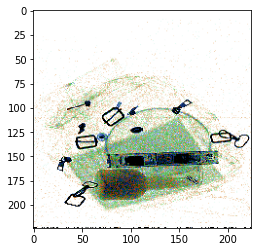

In [82]:
img_path = 'train/bags/xray_00015.png'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

## Создаем наборы данных

Набор данных для обучения

In [83]:
train_dataset = image_dataset_from_directory('train',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 972 files belonging to 2 classes.


In [84]:
class_names = train_dataset.class_names

In [85]:
class_names

['bags', 'guns']

Набор данных для тестирования

In [86]:
test_dataset = image_dataset_from_directory('test',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 972 files belonging to 2 classes.


## Создаем составную нейронную сеть

In [87]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [88]:
inputs = layers.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)
model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# Для задачи с двумя классами изображений
outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
# Для задачи с несколькими классами изображений
# num_classes = 3 # Задаем количество классов
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

16705208/16705208 [==============================] - 1s 0us/step


Компилируем составную нейронную сеть

In [89]:
# Для задачи с двумя классами изображений
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
# Для задачи с несколькими классами изображений
# model.compile(loss='categorical_crossentropy',
#              optimizer='adam', 
#              metrics=['accuracy'])

## Обучаем сеть

In [90]:
history = model.fit(train_dataset,
                    epochs=10)

Epoch 1/10


8/8 [==============================] - 37s 2s/step - loss: 0.7225 - accuracy: 0.6193
Epoch 2/10
8/8 [==============================] - 19s 2s/step - loss: 0.2880 - accuracy: 0.8776
Epoch 3/10
8/8 [==============================] - 19s 2s/step - loss: 0.2018 - accuracy: 0.9239
Epoch 4/10
8/8 [==============================] - 19s 2s/step - loss: 0.1760 - accuracy: 0.9527
Epoch 5/10
8/8 [==============================] - 20s 2s/step - loss: 0.1586 - accuracy: 0.9496
Epoch 6/10
8/8 [==============================] - 19s 2s/step - loss: 0.1376 - accuracy: 0.9599
Epoch 7/10
8/8 [==============================] - 19s 2s/step - loss: 0.1284 - accuracy: 0.9496
Epoch 8/10
8/8 [==============================] - 19s 2s/step - loss: 0.1295 - accuracy: 0.9558
Epoch 9/10
8/8 [==============================] - 20s 2s/step - loss: 0.1178 - accuracy: 0.9650
Epoch 10/10
8/8 [==============================] - 19s 2s/step - loss: 0.1004 - accuracy: 0.9691


Проверяем качество обучения на тестовом наборе данных


In [91]:
scores = model.evaluate(test_dataset, verbose=1)

8/8 [==============================] - 7s 242ms/step - loss: 0.2557 - accuracy: 0.9064


In [92]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 90.6379


## Использование нейронной сети для распознавания изображений

Вспоминаем номера классов

In [93]:
class_names

['bags', 'guns']

Загружаем изображение из файла

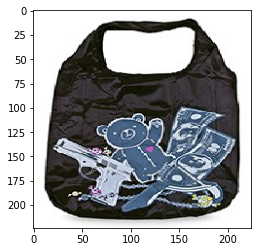

In [95]:
img_path = 'test/guns/000006.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

Преобразуем изображение в массив

In [96]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

Запускаем распознавание

In [97]:
prediction = model.predict(x)

1/1 [==============================] - 2s 2s/step


Печатаем результаты распознавания

In [98]:
prediction

array([[0.8279642]], dtype=float32)